Basé sur l'article "[The KL-UCB algortihm for bounded stochastic bandits and beyond](https://arxiv.org/abs/1102.2490)" de **Aurélien Garivier** et **Olivier Cappé**.

In [63]:
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [64]:
%load_ext autoreload
%autoreload 2
import kl_ucb_policy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
#Paramètres du scenario 2
# p = np.array([.99, .98, .96, .93, .90, .10, .06, .04]) #Bernoulli Parameters
# p = np.array([.95, .90, .80, .65, .45, .25, .15, .10])
p = np.array([.90, .80, .70, .55, .45, .35, .20, .10])
rate = np.array([6, 9, 12, 18, 24, 36, 48, 54])
tp = np.multiply(p,rate)

K= p.shape[0] #Number of branches
delta= ( np.ones(K)*np.max(tp) ) - tp

T= 5000 #Time periods
runs = 1 #Number of iterations

print("Pi:",p)
print("delta:",delta)

Pi: [0.9  0.8  0.7  0.55 0.45 0.35 0.2  0.1 ]
delta: [7.2 5.4 4.2 2.7 1.8 0.  3.  7.2]


## KL-UCB

In [66]:
%%capture
klucb_dichotomie = kl_ucb_policy.KLUCBPolicy(K, rate, kl_ucb_policy.klucb_upper_bisection)

total_rewards_list_klucb_dichotomie = np.zeros((runs,T))
actions_list_klucb_dichotomie = []
start_time = time.time()

for run in range(runs):
    klucb_dichotomie.reset()
    actions = np.zeros((K, T), dtype=np.int)
    rewards = np.zeros((K, T), dtype=np.float)

    for t in range(T):
        arm = klucb_dichotomie.select_next_arm()
        actions[arm, t] = 1
        rewards[arm, t] = np.random.binomial(1, p[arm])*rate[arm]
        klucb_dichotomie.update_state(arm, rewards[arm, t]/rate[arm])

    cumulative_rewards = np.cumsum(rewards, axis=1) #Cumulative rewards of each arm according to time
    total_rewards = np.sum(cumulative_rewards, axis=0) #Cumulative rewards of all arms according to time
    total_rewards_list_klucb_dichotomie[run,:] = np.copy(total_rewards)
    actions_list_klucb_dichotomie.append(np.copy(actions))

time_spent_klucb_dichotomie = time.time() - start_time

In [67]:
print("Time for KL-UCB (Newton), with T =", T, ", runs =", runs, ":", (time_spent_klucb_dichotomie), "seconds")

Time for KL-UCB (Newton), with T = 5000 , runs = 1 : 0.5741293430328369 seconds


## Résultats

## Gain total moyen

In [68]:
mean_total_rewards_list_klucb_dichotomie = np.mean(total_rewards_list_klucb_dichotomie, axis=0)
print("t & Reward (total) KL-UCB :",t, mean_total_rewards_list_klucb_dichotomie[t] )

t & Reward (total) KL-UCB : 4999 61017.0


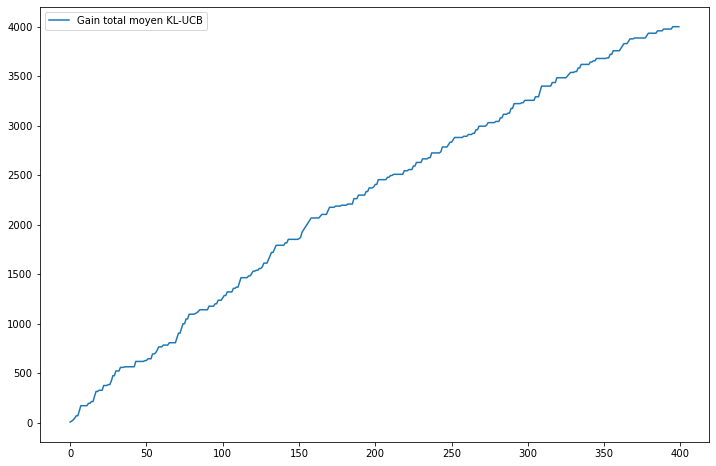

In [69]:
fig=plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(mean_total_rewards_list_klucb_dichotomie[:400],linestyle='-',label='Gain total moyen KL-UCB')
ax1.legend(loc='best')
plt.show()

In [70]:
#KL-UCB
total_action_klucb = np.zeros((K,T))
for actions_klucb in actions_list_klucb_dichotomie:
    total_action_klucb += np.cumsum(actions_klucb, axis=1) #The cumulative times of each arm to be selected
total_action_klucb = total_action_klucb / runs
regret_cumule_klucb = np.dot(delta, total_action_klucb[:,:]) # Cumulative regrets

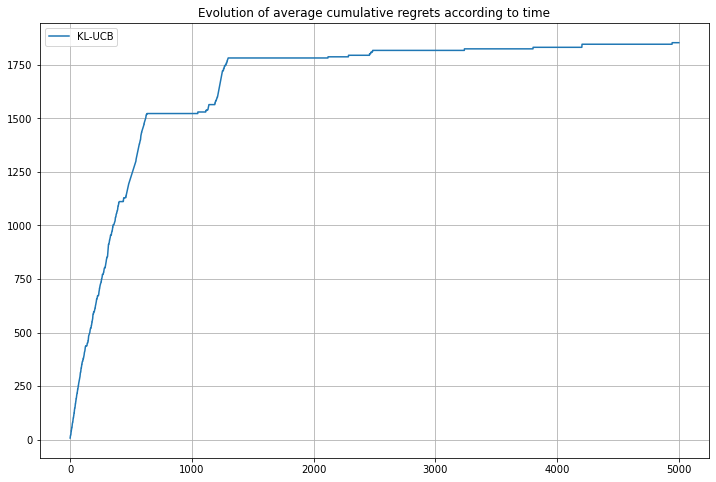

In [71]:
fig=plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1,1,1)

ax1.plot(regret_cumule_klucb[:],linestyle='-', label='KL-UCB')

ax1.legend(loc='best')
ax1.grid()
ax1.set_title('Evolution of average cumulative regrets according to time')
#ax1.xscale('log')
plt.show()

## Distribution du regret

In [72]:
T0 = 4999

In [73]:
#KL-UCB
distribution_regret_klucb = []
for actions_klucb in actions_list_klucb_dichotomie:
    distribution_regret_klucb.append(np.dot(delta, np.sum(actions_klucb[:,:T0], axis=1)))

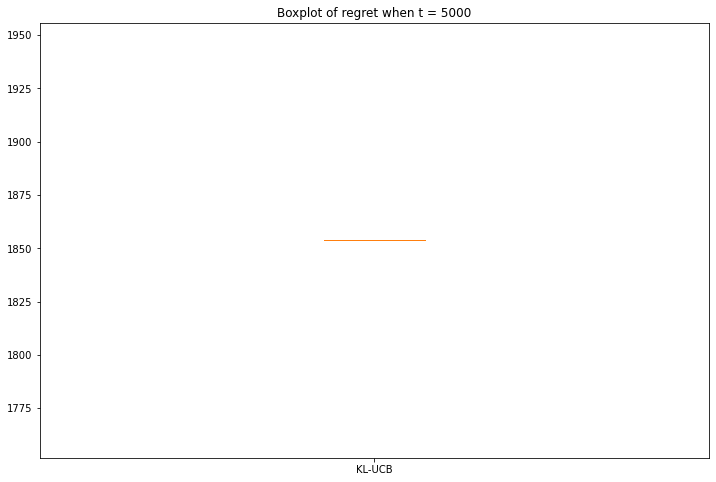

In [74]:
fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

ax.boxplot([
        distribution_regret_klucb
    ])
ax.set_xticklabels([
        'KL-UCB'
    ])

ax.set_title('Boxplot of regret when t = 5000')
plt.show()